In [ ]:
# Tb classifier with original images and two classes: Got marginally better accuracy than when we use segmented images
import tensorflow as tf
tf.test.gpu_device_name()

''

In [ ]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
# Defining the classes
classes = ["normal", "ptb"]

In [ ]:
import tensorflow as tf

In [ ]:
# Defining the argument for getting the train and test data from the drive
args = {
    "labels": "inferred",
    "label_mode": "categorical",
    "batch_size": 32,
    "image_size": (256, 256),
    "seed": 1,
    "validation_split": .2,
    "class_names": classes
}

In [ ]:
# Accessing train and test datasets
train = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/Classifier_input_org_img",
    subset="training",
    **args
)

test = tf.keras.utils.image_dataset_from_directory(
  "/content/drive/MyDrive/Classifier_input_org_img",
  subset="validation",
    **args
)

Found 628 files belonging to 2 classes.
Using 503 files for training.
Found 628 files belonging to 2 classes.
Using 125 files for validation.


In [ ]:
# Checking the first element
first = train.take(1)
first

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

In [ ]:
# To visualize the first image
images, labels = list(first)[0]
first_image = images[0]

In [ ]:
first_image[:3,:3,0]

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[ 1.      , 69.29492 , 70.975075],
       [ 1.      , 70.43222 , 64.709656],
       [ 1.      , 62.457367, 59.60305 ]], dtype=float32)>

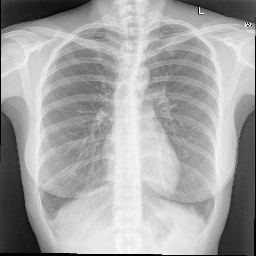

In [ ]:
from PIL import Image

Image.fromarray(images[0].numpy().astype("uint8"))

In [ ]:
train = train.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test = test.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
# Making a simple sequential model
model = Sequential([
  tf.keras.layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(256,256,3)),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(classes))
])

In [ ]:
# Using SGD as the optimizer, we also tried Adams at the begining
model.compile(optimizer='sgd',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# Storing the mode fit
history = model.fit(
    train,
    validation_data=test,
    epochs=10,
    verbose=1
)

Epoch 1/10
16/16 [==============================] - 109s 5s/step - loss: 3.9661 - accuracy: 0.6402 - val_loss: 0.6509 - val_accuracy: 0.7280
Epoch 2/10
16/16 [==============================] - 27s 2s/step - loss: 0.6177 - accuracy: 0.7515 - val_loss: 0.6039 - val_accuracy: 0.7200
Epoch 3/10
16/16 [==============================] - 27s 2s/step - loss: 0.5825 - accuracy: 0.7515 - val_loss: 0.5811 - val_accuracy: 0.7280
Epoch 4/10
16/16 [==============================] - 27s 2s/step - loss: 0.5820 - accuracy: 0.7217 - val_loss: 0.5684 - val_accuracy: 0.7360
Epoch 5/10
16/16 [==============================] - 27s 2s/step - loss: 0.5266 - accuracy: 0.7674 - val_loss: 0.5555 - val_accuracy: 0.7360
Epoch 6/10
16/16 [==============================] - 27s 2s/step - loss: 0.5093 - accuracy: 0.7694 - val_loss: 0.5390 - val_accuracy: 0.7360
Epoch 7/10
16/16 [==============================] - 27s 2s/step - loss: 0.4830 - accuracy: 0.7833 - val_loss: 0.5123 - val_accuracy: 0.7680
Epoch 8/10
16/16 [=

In [ ]:
# Displaying the model summary of basic models
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 flatten (Flatten)           (None, 1048576)           0         
                                                                 
 dense (Dense)               (None, 128)               134217856 
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 134,218,562
Trainable params: 134,218,562
Non-trainable params: 0
_________________________________________________________________


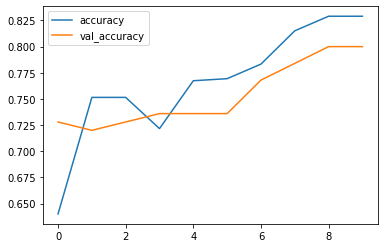

In [ ]:
import pandas as pd
# Plotting training and validation accuracy
history_df = pd.DataFrame.from_dict(history.history)
history_df[["accuracy", "val_accuracy"]].plot()


In [ ]:
# Defining a more complex model to improve performance

def train_model(network, epochs=15):
    model = Sequential(network)

    model.compile(optimizer='sgd',
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    history = model.fit(
      train,
      validation_data=test,
      epochs=epochs
    )
    history_df = pd.DataFrame.from_dict(history.history)
    return history_df, model

In [ ]:
# Defining the network and layers in detail

network = [
  tf.keras.layers.Rescaling(1./255),
  layers.Conv2D(16, 4, padding='same', activation='relu', input_shape=(256,256,3)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(classes))
]

history_df, model = train_model(network)

Epoch 1/15
16/16 [==============================] - 49s 3s/step - loss: 0.7087 - accuracy: 0.5308 - val_loss: 0.6769 - val_accuracy: 0.7040
Epoch 2/15
16/16 [==============================] - 48s 3s/step - loss: 0.6765 - accuracy: 0.5885 - val_loss: 0.6571 - val_accuracy: 0.7840
Epoch 3/15
16/16 [==============================] - 48s 3s/step - loss: 0.6642 - accuracy: 0.6302 - val_loss: 0.6333 - val_accuracy: 0.7120
Epoch 4/15
16/16 [==============================] - 48s 3s/step - loss: 0.6458 - accuracy: 0.6700 - val_loss: 0.6081 - val_accuracy: 0.7120
Epoch 5/15
16/16 [==============================] - 49s 3s/step - loss: 0.6345 - accuracy: 0.6640 - val_loss: 0.5853 - val_accuracy: 0.7120
Epoch 6/15
16/16 [==============================] - 48s 3s/step - loss: 0.6060 - accuracy: 0.6998 - val_loss: 0.5949 - val_accuracy: 0.6320
Epoch 7/15
16/16 [==============================] - 48s 3s/step - loss: 0.5903 - accuracy: 0.7197 - val_loss: 0.6081 - val_accuracy: 0.6000
Epoch 8/15
16/16 [==

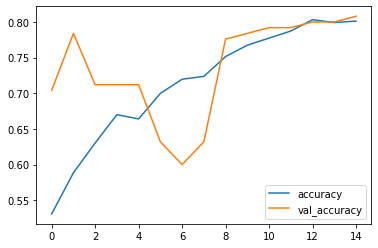

In [ ]:
# Plotting the training and validation accuracy of improved model

history_df[["accuracy", "val_accuracy"]].plot()

In [ ]:
# Plotting the summary of new model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 16)      784       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)       

In [22]:
# Trying to do data augmentation for improved performance

data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("vertical", seed=1),
      layers.RandomRotation(0.2, seed=1),
    layers.RandomZoom(0.2, seed=1),
  ]
)


full_network = [
    data_augmentation
] + network

history_df, model = train_model(full_network, epochs=40)

Epoch 1/40
16/16 [==============================] - 55s 3s/step - loss: 0.6935 - accuracy: 0.5885 - val_loss: 0.5277 - val_accuracy: 0.7760
Epoch 2/40
16/16 [==============================] - 53s 3s/step - loss: 0.6597 - accuracy: 0.6044 - val_loss: 0.5202 - val_accuracy: 0.7680
Epoch 3/40
16/16 [==============================] - 55s 3s/step - loss: 0.6627 - accuracy: 0.5944 - val_loss: 0.5101 - val_accuracy: 0.7680
Epoch 4/40
16/16 [==============================] - 52s 3s/step - loss: 0.6471 - accuracy: 0.6322 - val_loss: 0.4861 - val_accuracy: 0.7760
Epoch 5/40
16/16 [==============================] - 52s 3s/step - loss: 0.6472 - accuracy: 0.6223 - val_loss: 0.4819 - val_accuracy: 0.8000
Epoch 6/40
16/16 [==============================] - 52s 3s/step - loss: 0.6467 - accuracy: 0.6223 - val_loss: 0.4669 - val_accuracy: 0.8000
Epoch 7/40
16/16 [==============================] - 52s 3s/step - loss: 0.6304 - accuracy: 0.6620 - val_loss: 0.4705 - val_accuracy: 0.7840
Epoch 8/40
16/16 [==

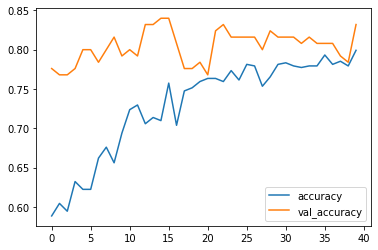

In [23]:
history_df[["accuracy", "val_accuracy"]].plot()

In [24]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 16)      784       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                  

In [25]:
preds = model.predict(test)

4/4 [==============================] - 3s 696ms/step


In [26]:
import numpy as np
predicted_class = np.argmax(preds, axis=1)

In [27]:
actual_labels = np.concatenate([y for x, y in test], axis=0)

In [28]:
import itertools

actual_image = [x.numpy().astype("uint8") for x, y in test]
actual_image = list(itertools.chain.from_iterable(actual_image))
actual_image = [Image.fromarray(a) for a in actual_image]

In [29]:
actual_class = np.argmax(actual_labels, axis=1)

In [30]:
pred_df = pd.DataFrame(zip(predicted_class, actual_class, actual_image), columns=["prediction", "actual", "image"])

In [31]:
pred_df["prediction"] = pred_df["prediction"].apply(lambda x: classes[x])
pred_df["actual"] = pred_df["actual"].apply(lambda x: classes[x])

In [32]:
import base64
import io

def image_formatter(img):
    with io.BytesIO() as buffer:
        img.save(buffer, 'png')
        img_str = base64.b64encode(buffer.getvalue()).decode()
        return f'{img_str}">'

pred_df.head(10).style.format({'image': image_formatter})

In [33]:
from sklearn import metrics
# Predicted values
y_pred = pred_df["prediction"]
# Actual values
y_act = pred_df["actual"]
# Printing the confusion matrix
# The columns will show the instances predicted for each label,
# and the rows will show the actual number of instances for each label.
print(metrics.confusion_matrix(y_act, y_pred, labels=["normal", "ptb"]))
# Printing the precision and recall, among other metrics
print(metrics.classification_report(y_act, y_pred, labels=["normal", "ptb"]))

[[57  7]
 [14 47]]
              precision    recall  f1-score   support

      normal       0.80      0.89      0.84        64
         ptb       0.87      0.77      0.82        61

    accuracy                           0.83       125
   macro avg       0.84      0.83      0.83       125
weighted avg       0.84      0.83      0.83       125

